In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import random
from statsmodels.stats.power import tt_ind_solve_power


def date_converter(x):
    return datetime.datetime.strptime(x, '%Y-%m-%d')

### Задание 3
**Срок сдачи: 07 апреля 18:00**

В этом задание вы будете работать с выручкой - метрикой с достаточно высокой дисперсией и соответсвенно низкой чувствительностью к изменениям.

Вам предстоит разработать подход по повышению чувствительности этой метрики.
От успеха данной инициативы зависит то, как быстро мы сможем проверять продуктовые гипотезы.

#### Для планирования эксперимента изучите данные и метрики 2 балла:

- Загрузите файл и изучите данные;
- Изучите основные статистики метрики: среднее, стандартное отклонение;
- Изучите то, как эти статистики изменяются внутри срезов: user_segment, region, category

#### Предскажите минимально детектируемый эффект (MDE) 2 балла:

- Для размеров тестовых групп 10,25,50% и длительностей 30, 60, 90 дней предскажите минимально детектируемый эффект;


#### CUPED 6 баллов
Разработайте подход по снижению дисперсии на основе методики CUPED:

- Рассчитайте CUPED метрику на основе данных за периода в 30 дней перед предполагаемым периодом сбора основной выборки и опишите как изменился MDE для выборок 50/50%, собранных за 30 дней (2 балла). 
- Проверьте насколько данный подход подвержен сезональности. Как меняется MDE, если применять данный подход в разные периоды (2 балла). 
- Оптимизируйте подход, варьируя количество дней до теста, которые вы будете для расчёта CUPED метрики. Какое максимальное снижение MDE вы смогли достичь (2 балла).



#### * Стратификация 4 балла (задание для получения дополнительных баллов)
Разработайте подход по снижению дисперсии на основе методики стратификации выборок:

- Стратифицируйте выборки внутри срезов user_segment, region, category
- Рассчитайте стратифицированные среднее,стандартное отклонение для этих выборок и MDE для теста 50/50% длительностью 30 дней.
- В каких срезах достигается наибольшее снижение MDE?



## Изучение данных

#### Описание данныx

event_date - дата 

user_id - идентификатор пользователя

user_segment - сегмент пользователей

region - регион

category - категория авито

revenue_amount - сумма покупок


In [2]:
df = pd.read_csv('user_amount_var_reduction.csv')
df['event_date'] = df.event_date.apply(date_converter)

In [3]:
df

,event_date,user_id,user_segment,category,region,revenue_amount
0,2019-06-18,4129257975403696,4626944681007198896,7204754148424990691,2201388710798473628,139
1,2019-06-18,7225254357470025,4626944681007198896,57514010642945023,3048517866726460689,193
2,2019-06-18,8912846500600569,4626944681007198896,5983323600580891431,3048517866726460689,160
3,2019-06-18,20910801279823046,4626944681007198896,6847326422676498281,7762196236856042106,209
4,2019-06-18,34873300821657220,2376074197230840906,3187769798308634693,3855810523611026650,160
...,...,...,...,...,...,...
8625837,2019-12-08,9170823997728769058,2376074197230840906,4658595883120885993,3855810523611026650,133
8625838,2019-12-08,9178869387857307556,4626944681007198896,1472231361867825698,3048517866726460689,63
8625839,2019-12-08,9186690404771258365,2376074197230840906,4546178272531746227,8867014108346120905,168
8625840,2019-12-08,9195678548159495844,2376074197230840906,5983323600580891431,1187552825302355021,118


In [4]:
df.revenue_amount.describe()

count    8.625842e+06
mean     4.009047e+02
std      9.602217e+02
min      1.000000e+00
25%      8.800000e+01
50%      1.670000e+02
75%      4.050000e+02
max      2.881230e+05
Name: revenue_amount, dtype: float64

In [5]:
df.revenue_amount.mean()

400.9046571917269

In [6]:
df.revenue_amount.std()

960.2217414899778

Text(0.5, 1.0, '99% percentile of revenue amount')

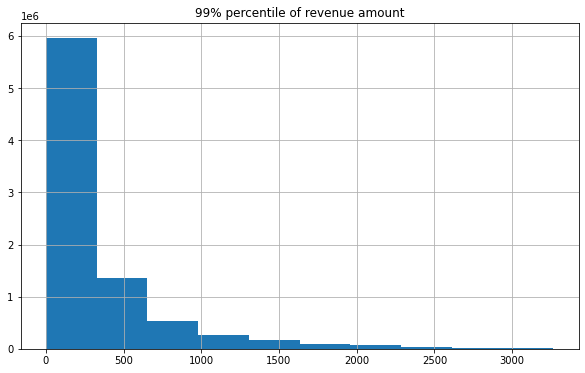

In [7]:
mask1 = df.revenue_amount < np.quantile(df.revenue_amount, 0.99)
df[mask1].revenue_amount.hist(bins=10, figsize=(10, 6)).set_title('99% percentile of revenue amount')

In [8]:
mask2 = df.revenue_amount >= np.quantile(df.revenue_amount, 0.99)
df[mask2].revenue_amount.count()

86271

In [9]:
len(df[mask2].revenue_amount.unique())

12094

<AxesSubplot:>

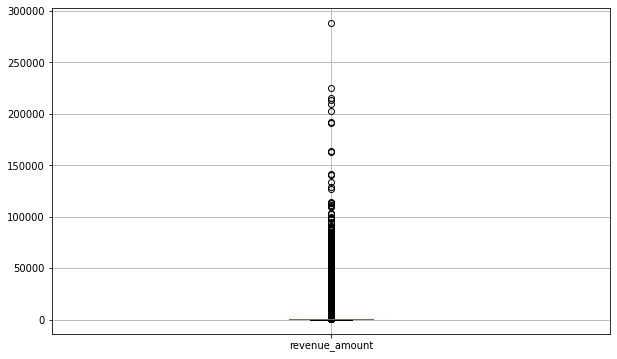

In [10]:
df.boxplot('revenue_amount', figsize=(10, 6))

Посмотрим как выглядит среднее и стандартное отклонение в разных сегментах пользователей

In [11]:
user_segments = df.groupby('user_segment')

In [12]:
user_segments.revenue_amount.mean()

user_segment
853431062533847667     1094.330305
2376074197230840906     401.615956
4626944681007198896     207.760172
Name: revenue_amount, dtype: float64

In [13]:
user_segments.revenue_amount.std()

user_segment
853431062533847667     2392.330098
2376074197230840906     571.446013
4626944681007198896     285.545686
Name: revenue_amount, dtype: float64

Видим, что один сегмент значительно больше двух других, причём имеет высокое стандартное отклонение.

Теперь в зависимости от региона

In [14]:
regions = df.groupby('region')

In [15]:
len(regions)

84

In [16]:
reg_means = regions.revenue_amount.mean()
reg_means

region
68475388295793322      289.345317
181387893390186210     299.629748
308194675497345788     252.626919
385667469633138042     272.589534
405364780634206711     205.209615
                          ...    
9030439280442565223    241.213507
9032475813655386611    341.125571
9159753098538066161    324.889870
9173615405044165275    189.498536
9198008870977546443    369.359878
Name: revenue_amount, Length: 84, dtype: float64

In [17]:
reg_std = regions.revenue_amount.std()
reg_std

region
68475388295793322      504.681673
181387893390186210     461.930430
308194675497345788     544.986118
385667469633138042     507.917500
405364780634206711     295.197711
                          ...    
9030439280442565223    374.722208
9032475813655386611    583.562907
9159753098538066161    721.907652
9173615405044165275    230.607352
9198008870977546443    613.172957
Name: revenue_amount, Length: 84, dtype: float64

Посмотрим на минимальное и максимальное значения у среднего

In [18]:
reg_means.min(), reg_means.max()

(182.15725288831837, 709.1307620881948)

Регионов значительно больше, чем сегментов пользователей, поэтому рассмотрим значения на гистограмме

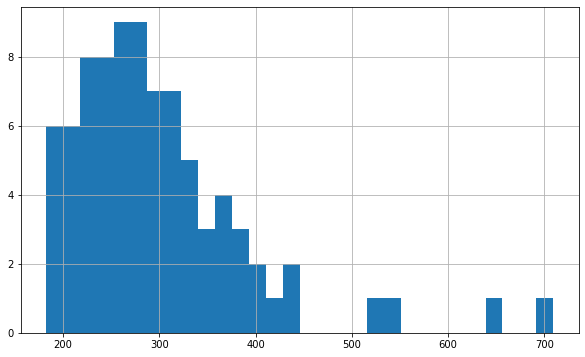

In [19]:
fig = plt.subplots(figsize=(10, 6))
plt.hist(reg_means, bins=30)
plt.grid()

In [20]:
reg_means[reg_means > 400]

region
690419174463540260     400.174691
1283565572874511058    429.396718
1481836092404435976    709.130762
1611023233668261710    529.945146
4459452014453832958    422.769579
4848067518890897757    644.019141
5780543780372929118    536.875280
8867014108346120905    445.188098
Name: revenue_amount, dtype: float64

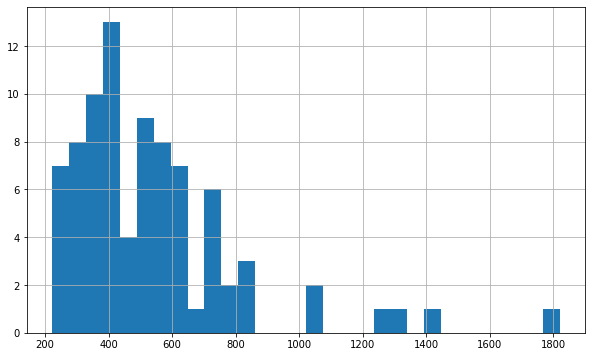

In [21]:
fig = plt.subplots(figsize=(10, 6))
plt.hist(reg_std, bins=30)
plt.grid()

У регионов основная масса по среднему распределена в промежутке от 180 до 400, и имеются 8 регионов, которые выше этих значений вплоть до 710.

Также рассмотрим разбивку по категориям

In [22]:
categories = df.groupby('category')

In [23]:
len(categories)

33

Посмотрим на минимальное и максимальное значения у среднего

In [24]:
cat_means = categories.revenue_amount.mean()
cat_std = categories.revenue_amount.std()

In [25]:
cat_means.min(), cat_means.max()

(136.59502923724799, 1955.9794312426957)

Категории тоже посмотрим на графиках

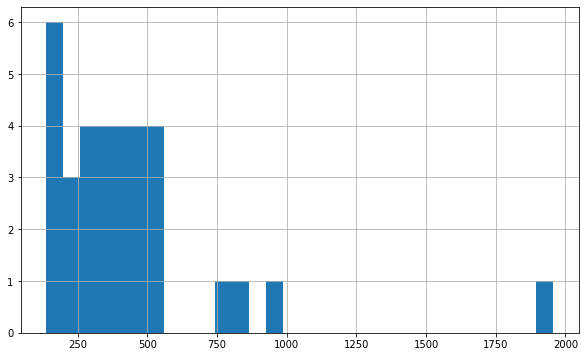

In [26]:
fig = plt.subplots(figsize=(10, 6))
plt.hist(cat_means, bins=30)
plt.grid()

In [27]:
cat_means[cat_means > 500]

category
264558924403680107      509.373364
2343719193625129042     943.989905
2923341857645916506     806.675364
4546178272531746227     510.431362
5858189596811644833     527.746677
6742557862815872936     503.182713
7164285449278522823    1955.979431
7948270325129383019     792.677807
Name: revenue_amount, dtype: float64

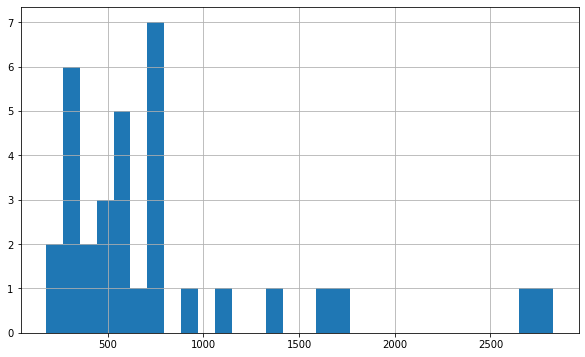

In [30]:
fig = plt.subplots(figsize=(10, 6))
plt.hist(cat_std, bins=30)
plt.grid()

У категорий основная масса по среднему распределена в промежутке от 130 до 530, и имеются 8 категорий, которые выше этих значений вплоть до 2000.

## MDE

In [28]:
from statsmodels.stats.power import tt_ind_solve_power


def choose_date(data, start_date, delta, share): 
    tmp = data[
        (data.event_date >= start_date) &
        (data.event_date <= start_date + datetime.timedelta(days=delta))
    ]
    tmp = tmp.groupby('user_id').sum().reset_index()
    x = tmp[tmp.user_id % 100 <= 100*share].reset_index()
    return x

Для размеров тестовых групп 10%, 25%, 50% и длительностей 30, 60, 90 дней предскажем минимально детектируемый эффект

In [29]:
df.event_date.min()

Timestamp('2019-06-18 00:00:00')

In [30]:
mde = 1
for share in [0.1, 0.25, 0.5]:
    for delta in [30, 60, 90]:
        x1 = choose_date(df, datetime.datetime(2019, 6, 18, 0, 0), delta, share)  # получаем необходимую подвыборку

        mean = x1.revenue_amount.mean()
        std = x1.revenue_amount.std()

        alpha = 0.01
        power = 0.8
        effects = np.linspace(0.5, 0.001, 1000)

        for result_effect in effects:
            effect_size = (mean / std) * result_effect

            sample_vol = tt_ind_solve_power(effect_size=effect_size,
                                            alpha=alpha,
                                            power=power,
                                            nobs1=None,
                                            ratio=1,
                                            alternative='two-sided')
            if sample_vol / x1.shape[0] <= 1:
                mde = result_effect
                
        print(f'При продолжительности эксперимента {delta} дней и размере тестовых групп {100*share}% MDE = {mde}')

При продолжительности эксперимента 30 дней и размере тестовых групп 10.0% MDE = 0.12787287287287286
При продолжительности эксперимента 60 дней и размере тестовых групп 10.0% MDE = 0.12637437437437438
При продолжительности эксперимента 90 дней и размере тестовых групп 10.0% MDE = 0.12287787787787785
При продолжительности эксперимента 30 дней и размере тестовых групп 25.0% MDE = 0.09340740740740738
При продолжительности эксперимента 60 дней и размере тестовых групп 25.0% MDE = 0.09041041041041037
При продолжительности эксперимента 90 дней и размере тестовых групп 25.0% MDE = 0.08991091091091091
При продолжительности эксперимента 30 дней и размере тестовых групп 50.0% MDE = 0.05894194194194191
При продолжительности эксперимента 60 дней и размере тестовых групп 50.0% MDE = 0.05744344344344343
При продолжительности эксперимента 90 дней и размере тестовых групп 50.0% MDE = 0.05744344344344343


Как видим MDE не сильно зависит от длительности эксперимента: изменения небольшие (в тысячных). При увеличении размера выборок MDE понижается уже более значительно, но при самых сильных условиях, когда и длительность самая большая (из предложенных) и размер выборки наибольший, то составляет чуть меньше 6%, что для выручки довольно много (если это не какой-то небольшой бизнес, а уже устоявшийся, придётся вводит какое-то сильное изменение, чтобы достигнуть такого). 

Нужно уменьшить дисперсию, и посмотреть на результаты, когда тесты будут более чувствительны.
## CUPED

In [31]:
def choose_pre_period(data, start_date, delta, users): 
    tmp = data[
        (data.event_date >= start_date) &
        (data.event_date <= start_date + datetime.timedelta(days=delta)) &
        (data.user_id.isin(users))  # берём только тех, кто будет в основной выборке
    ]
    tmp = tmp.groupby('user_id').sum().reset_index()
    return tmp

Возьмём второй месяц от начальной даты за текущий период (основная выборка), тогда месяц с начальной даты будет предпериодом, размер выборки берём 50/50%.

In [32]:
x = choose_date(df, datetime.datetime(2019, 7, 18, 0, 0), 30, 0.5)
pre_x = choose_pre_period(df, datetime.datetime(2019, 6, 18, 0, 0), 30, x.user_id)

In [33]:
data = x.merge(right=pre_x[['user_id', 'revenue_amount']], how='left', on='user_id')
data

,index,user_id,user_segment,category,region,revenue_amount_x,revenue_amount_y
0,0,702221222224,4.626945e+18,6.742558e+18,2.201389e+18,356.0,NaN
1,6,73834573097944,9.253889e+18,6.813584e+18,2.232932e+18,2392.0,NaN
2,8,87029396555710,4.626945e+18,1.560592e+18,6.847539e+16,111.0,NaN
3,9,88433173713624,4.752148e+18,3.489802e+17,6.826400e+18,68.0,NaN
4,10,111281855931038,4.626945e+18,6.742558e+18,5.780544e+18,139.0,NaN
...,...,...,...,...,...,...,...
305292,599025,9223242627945572242,4.626945e+18,7.247165e+18,1.481836e+18,322.0,NaN
305293,599027,9223307794984562620,4.626945e+18,4.394253e+18,4.607638e+18,196.0,NaN
305294,599030,9223348554567144516,4.626945e+18,4.394253e+18,3.413200e+18,49.0,55.0
305295,599031,9223366785772814828,9.504297e+18,1.275108e+19,5.861974e+18,4448.0,3336.0


In [34]:
data.fillna(0, inplace=True)
data.rename(columns={
    'revenue_amount_x': 'revenue_amount',
    'revenue_amount_y': 'pre_revenue_amount'
}, inplace=True)

Считаем среднее предданных

In [35]:
data['pre_revenue_avg'] = data.pre_revenue_amount.mean()

Считаем множитель для CUPED

In [36]:
theta = np.cov(data.revenue_amount, data.pre_revenue_amount, ddof=1)[1,0] / \
        np.var(data.pre_revenue_amount, ddof=1)

In [37]:
corr = np.corrcoef(data.revenue_amount, data.pre_revenue_amount)[1,0] 

Считаем CUPED-метрику

In [38]:
data['cuped_revenue_amount'] = data.revenue_amount - theta * (data.pre_revenue_amount - data.pre_revenue_avg)

In [39]:
data

,index,user_id,user_segment,category,region,revenue_amount,pre_revenue_amount,pre_revenue_avg,cuped_revenue_amount
0,0,702221222224,4.626945e+18,6.742558e+18,2.201389e+18,356.0,0.0,802.732022,1040.736240
1,6,73834573097944,9.253889e+18,6.813584e+18,2.232932e+18,2392.0,0.0,802.732022,3076.736240
2,8,87029396555710,4.626945e+18,1.560592e+18,6.847539e+16,111.0,0.0,802.732022,795.736240
3,9,88433173713624,4.752148e+18,3.489802e+17,6.826400e+18,68.0,0.0,802.732022,752.736240
4,10,111281855931038,4.626945e+18,6.742558e+18,5.780544e+18,139.0,0.0,802.732022,823.736240
...,...,...,...,...,...,...,...,...,...
305292,599025,9223242627945572242,4.626945e+18,7.247165e+18,1.481836e+18,322.0,0.0,802.732022,1006.736240
305293,599027,9223307794984562620,4.626945e+18,4.394253e+18,4.607638e+18,196.0,0.0,802.732022,880.736240
305294,599030,9223348554567144516,4.626945e+18,4.394253e+18,3.413200e+18,49.0,55.0,802.732022,686.820841
305295,599031,9223366785772814828,9.504297e+18,1.275108e+19,5.861974e+18,4448.0,3336.0,802.732022,2287.104029


In [40]:
mean = data.cuped_revenue_amount.mean()
std = data.cuped_revenue_amount.std()

alpha = 0.01
power = 0.8
effects = np.linspace(0.5, 0.001, 1000)

for result_effect in effects:
    effect_size = (mean / std) * result_effect

    sample_vol = tt_ind_solve_power(effect_size=effect_size,
                                    alpha=alpha,
                                    power=power,
                                    nobs1=None,
                                    ratio=1,
                                    alternative='two-sided')
    if sample_vol / data.shape[0] <= 1:
        mde = result_effect

print(f'MDE = {mde}')

MDE = 0.03396696696696694


MDE снизился до 3.4% с 5.7%, который был посчитан не по CUPED-метрике.

#### Теперь проверим, как меняется MDE, если брать разные периоды, подвержен ли он сезональности.

Шаг между периодами можно взять неделю, если брать меньше, то возможно не успеют набежать метрики значительно, поэтому неделя вполне сойдёт.

Посчитаем сколько шагов сделаем до дня, когда вычтем из максимальной даты месяц (последний возомжный основной период в 30 дней), начальную дату плюс месяц.

In [41]:
((df.event_date.max() - datetime.timedelta(days=30)) -
 (df.event_date.min() + datetime.timedelta(days=31))).days / 7

16.142857142857142

Вышло 16 шагов, то есть 16 полных недель.

Оформим код выше в отдельную функцию.

In [42]:
def calculate_mde(df, date, delta, share):
    x = choose_date(df, date, delta, share)
    pre_x = choose_pre_period(df, date - datetime.timedelta(days=30), 30, x.user_id)
    
    data = x.merge(right=pre_x[['user_id', 'revenue_amount']], how='left', on='user_id')
    data.fillna(0, inplace=True)
    data.rename(columns={
        'revenue_amount_x': 'revenue_amount',
        'revenue_amount_y': 'pre_revenue_amount'
    }, inplace=True)
    
    data['pre_revenue_avg'] = data.pre_revenue_amount.mean()
    theta = np.cov(data.revenue_amount, data.pre_revenue_amount, ddof=1)[1,0] / \
            np.var(data.pre_revenue_amount, ddof=1)
    corr = np.corrcoef(data.revenue_amount, data.pre_revenue_amount)[1,0]
    data['cuped_revenue_amount'] = data.revenue_amount - theta * (data.pre_revenue_amount - data.pre_revenue_avg)
    
    mean = data.cuped_revenue_amount.mean()
    std = data.cuped_revenue_amount.std()

    alpha = 0.01
    power = 0.8
    effects = np.linspace(0.5, 0.001, 1000)
    mde = 1
    
    for result_effect in effects:
        effect_size = (mean / std) * result_effect

        sample_vol = tt_ind_solve_power(effect_size=effect_size,
                                        alpha=alpha,
                                        power=power,
                                        nobs1=None,
                                        ratio=1,
                                        alternative='two-sided')
        if sample_vol / data.shape[0] <= 1:
            mde = result_effect
    
    return mde

In [43]:
MDEs = []
dates = []
min_date = datetime.datetime(2019, 7, 19, 0, 0)
min_mde = 1

for i in range(16):
    cur_date = datetime.datetime(2019, 7, 19, 0, 0) + datetime.timedelta(days=7*i)
    mde = calculate_mde(df, cur_date, 30, 0.5)
    
    if mde < min_mde:
        min_mde = mde
        min_date = cur_date
        
    MDEs.append(mde)
    dates.append(cur_date)

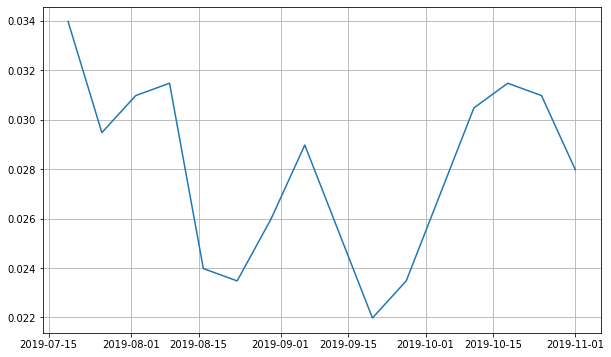

In [44]:
fig = plt.subplots(figsize=(10, 6))
plt.plot(dates, MDEs)
plt.grid()

In [45]:
print(f'Минимальный MDE в {min_mde} был достигнут в периоде с {min_date}')

Минимальный MDE в 0.021978978978978936 был достигнут в периоде с 2019-09-20 00:00:00


Видим из графика, что MDE зависит от даты, с которой берём период, то есть подвержен сезональности. Минимальный MDE с использованием CUPED-метрики в итоге вышел 2.2%, когда без неё был 5.7%.

#### Оптимизируем подход, варьируя количество дней до теста, которые будем брать для расчёта CUPED метрики.

Будем отодвигать на один день от тестового периода, который мы нашли выше, то есть 2019-09-20, мы можем отодвигать дату до тех пор, пока не дойдём до начальная дата плюс месяц (2019-07-19).

In [55]:
(datetime.datetime(2019, 9, 20, 0, 0) - datetime.timedelta(days=30)-
 datetime.datetime(2019, 7, 19, 0, 0)).days

33

In [52]:
def calculate_mde_with_shift(df, date, delta, share, shift):
    x = choose_date(df, date, delta, share)
    pre_x = choose_pre_period(df, date - datetime.timedelta(days=30+shift), 30, x.user_id)
    
    data = x.merge(right=pre_x[['user_id', 'revenue_amount']], how='left', on='user_id')
    data.fillna(0, inplace=True)
    data.rename(columns={
        'revenue_amount_x': 'revenue_amount',
        'revenue_amount_y': 'pre_revenue_amount'
    }, inplace=True)
    
    data['pre_revenue_avg'] = data.pre_revenue_amount.mean()
    theta = np.cov(data.revenue_amount, data.pre_revenue_amount, ddof=1)[1,0] / \
            np.var(data.pre_revenue_amount, ddof=1)
    corr = np.corrcoef(data.revenue_amount, data.pre_revenue_amount)[1,0]
    data['cuped_revenue_amount'] = data.revenue_amount - theta * (data.pre_revenue_amount - data.pre_revenue_avg)
    
    mean = data.cuped_revenue_amount.mean()
    std = data.cuped_revenue_amount.std()

    alpha = 0.01
    power = 0.8
    effects = np.linspace(0.5, 0.001, 1000)
    mde = 1
    
    for result_effect in effects:
        effect_size = (mean / std) * result_effect

        sample_vol = tt_ind_solve_power(effect_size=effect_size,
                                        alpha=alpha,
                                        power=power,
                                        nobs1=None,
                                        ratio=1,
                                        alternative='two-sided')
        if sample_vol / data.shape[0] <= 1:
            mde = result_effect
    
    return mde

In [61]:
MDEs = []
dates = []
min_date = datetime.datetime(2019, 9, 30, 0, 0)
min_mde = 1

for i in range(30):
    cur_date = datetime.datetime(2019, 9, 30, 0, 0) - datetime.timedelta(days=i)
    mde = calculate_mde_with_shift(df, cur_date, 30, 0.5, i)
    
    if mde < min_mde:
        min_mde = mde
        min_date = cur_date
        
    MDEs.append(mde)
    dates.append(cur_date)

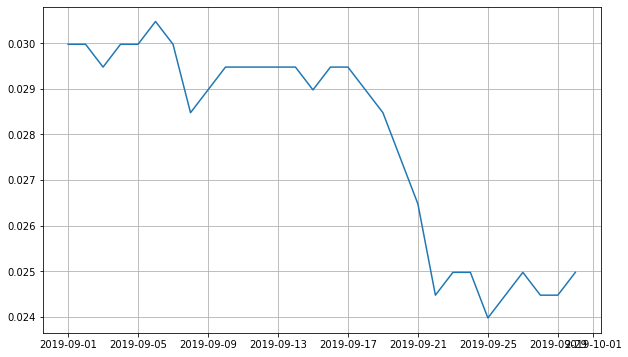

In [62]:
fig = plt.subplots(figsize=(10, 6))
plt.plot(dates, MDEs)
plt.grid()

Не получается опуститься ниже, чем было раньше.

### Стратификация

Сначала рассмотрим срез сегментов пользователей

In [108]:
x = choose_date(df, datetime.datetime(2019, 6, 18, 0, 0), 30, 0.5)  # получаем необходимую подвыборку
x.drop(columns=['index', 'category', 'region'], axis=1, inplace=True)

strata_p = x.groupby('user_segment').count() / x.count()[0]
data_strat = x.join(strata_p, on='user_segment', rsuffix='_probability')
data_strat.drop(['user_id_probability'], axis=1, inplace=True)

In [109]:
data_strat

,user_id,user_segment,revenue_amount,revenue_amount_probability
0,7562887359106,9.253889e+18,105.0,0.085235
1,133237288205136,4.626945e+18,160.0,0.413520
2,209672890150349,9.253889e+18,397.0,0.085235
3,239972521062310,9.253889e+18,574.0,0.085235
4,277934167554935,2.851289e+19,4832.0,0.001421
...,...,...,...,...
315276,9223230347802593537,1.850778e+19,514.0,0.014650
315277,9223281527007418220,4.626945e+18,288.0,0.413520
315278,9223306345881997142,4.626945e+18,195.0,0.413520
315279,9223348554567144516,9.253889e+18,55.0,0.085235


In [110]:
x.revenue_amount.mean()

987.4865786393725

In [111]:
strat_mean = (data_strat.groupby('user_segment').mean().revenue_amount *
              data_strat.groupby('user_segment').mean().revenue_amount_probability).sum()
strat_mean

987.4865786393725

Средние равны. Посмотрим теперь на стандартное отклонение

In [112]:
(x.revenue_amount.var())**0.5

6761.943172332728

In [113]:
strat_std = ((data_strat.groupby('user_segment').var().revenue_amount *
              data_strat.groupby('user_segment').mean().revenue_amount_probability).sum())**0.5
strat_std

3941.944580831538

In [114]:
alpha = 0.01
power = 0.8
effects = np.linspace(0.5, 0.001, 1000)

for result_effect in effects:
    effect_size = (strat_mean / strat_std) * result_effect

    sample_vol = tt_ind_solve_power(effect_size=effect_size,
                                    alpha=alpha,
                                    power=power,
                                    nobs1=None,
                                    ratio=1,
                                    alternative='two-sided')
    if sample_vol / data.shape[0] <= 1:
        mde = result_effect

print(f'MDE = {mde}')

MDE = 0.03496596596596596


MDE снизился, но не ниже, чем был получен с помощью CUPED-метрики.

Теперь посмотрим на срез регионов

In [115]:
x = choose_date(df, datetime.datetime(2019, 6, 18, 0, 0), 30, 0.5)  # получаем необходимую подвыборку
x.drop(columns=['index', 'category', 'user_segment'], axis=1, inplace=True)

strata_p = x.groupby('region').count() / x.count()[0]
data_strat = x.join(strata_p, on='region', rsuffix='_probability')
data_strat.drop(['user_id_probability'], axis=1, inplace=True)

data_strat

,user_id,region,revenue_amount,revenue_amount_probability
0,7562887359106,9.252526e+18,105.0,0.001408
1,133237288205136,6.681910e+18,160.0,0.014739
2,209672890150349,5.037762e+18,397.0,0.000469
3,239972521062310,1.513513e+19,574.0,0.000542
4,277934167554935,3.301742e+19,4832.0,0.000057
...,...,...,...,...
315276,9223230347802593537,1.939227e+19,514.0,0.002290
315277,9223281527007418220,3.048518e+18,288.0,0.014961
315278,9223306345881997142,3.856675e+17,195.0,0.003854
315279,9223348554567144516,6.826400e+18,55.0,0.002740


Проверяем средние

In [116]:
x.revenue_amount.mean()

987.4865786393725

In [117]:
strat_mean = (data_strat.groupby('region').mean().revenue_amount *
              data_strat.groupby('region').mean().revenue_amount_probability).sum()
strat_mean

987.4865786393725

Смотрим на отклонение

In [118]:
(x.revenue_amount.var())**0.5

6761.943172332728

In [119]:
strat_std = ((data_strat.groupby('region').var().revenue_amount *
              data_strat.groupby('region').mean().revenue_amount_probability).sum())**0.5
strat_std

3385.333982740641

In [120]:
alpha = 0.01
power = 0.8
effects = np.linspace(0.5, 0.001, 1000)

for result_effect in effects:
    effect_size = (strat_mean / strat_std) * result_effect

    sample_vol = tt_ind_solve_power(effect_size=effect_size,
                                    alpha=alpha,
                                    power=power,
                                    nobs1=None,
                                    ratio=1,
                                    alternative='two-sided')
    if sample_vol / data.shape[0] <= 1:
        mde = result_effect

print(f'MDE = {mde}')

MDE = 0.030470470470470468


На регионах MDE меньше, чем на сегментах пользователей, но всё равно больше, чем 2.2% на CUPED-метрике.

И рассмотрим по категориям

In [121]:
x = choose_date(df, datetime.datetime(2019, 6, 18, 0, 0), 30, 0.5)  # получаем необходимую подвыборку
x.drop(columns=['index', 'region', 'user_segment'], axis=1, inplace=True)

strata_p = x.groupby('category').count() / x.count()[0]
data_strat = x.join(strata_p, on='category', rsuffix='_probability')
data_strat.drop(['user_id_probability'], axis=1, inplace=True)

data_strat

,user_id,category,revenue_amount,revenue_amount_probability
0,7562887359106,1.449433e+19,105.0,0.003023
1,133237288205136,7.204754e+18,160.0,0.051792
2,209672890150349,3.586134e+18,397.0,0.006318
3,239972521062310,6.859028e+18,574.0,0.004770
4,277934167554935,8.645705e+19,4832.0,0.000133
...,...,...,...,...
315276,9223230347802593537,2.881902e+19,514.0,0.002648
315277,9223281527007418220,6.742558e+18,288.0,0.032114
315278,9223306345881997142,6.549026e+18,195.0,0.057127
315279,9223348554567144516,8.788507e+18,55.0,0.007631


Смотрим средние

In [122]:
x.revenue_amount.mean()

987.4865786393725

In [123]:
strat_mean = (data_strat.groupby('category').mean().revenue_amount *
              data_strat.groupby('category').mean().revenue_amount_probability).sum()
strat_mean

987.4865786393725

Отклонения

In [124]:
(x.revenue_amount.var())**0.5

6761.943172332728

In [125]:
strat_std = ((data_strat.groupby('category').var().revenue_amount *
              data_strat.groupby('category').mean().revenue_amount_probability).sum())**0.5
strat_std

3255.8185071954917

In [126]:
alpha = 0.01
power = 0.8
effects = np.linspace(0.5, 0.001, 1000)

for result_effect in effects:
    effect_size = (strat_mean / strat_std) * result_effect

    sample_vol = tt_ind_solve_power(effect_size=effect_size,
                                    alpha=alpha,
                                    power=power,
                                    nobs1=None,
                                    ratio=1,
                                    alternative='two-sided')
    if sample_vol / data.shape[0] <= 1:
        mde = result_effect

print(f'MDE = {mde}')

MDE = 0.028971971971971933


MDE вновь меньше, чем на предыдущих стратах, но глобально не меньше, чем 2.2%.

Таким образом изнчально MDE был 5.7% при длительности 90 дней. С применением различных способов понижения дисперсии удалось достичь 2.2% за более короткий период, что уже более менее соответсвует действительности.